# Lab 5: Data preprocessing and pipelines
We explore the performance of several linear regression models on a real-world dataset, i.e. [MoneyBall](https://www.openml.org/d/41021). See the description on OpenML for more information. In short, this dataset captures performance data from baseball players. The regression task is to accurately predict the number of 'runs' each player can score, and understanding which are the most important factors.

In [1]:
# General imports
%matplotlib inline
import pandas as pd
import openml as oml

In [2]:
# Download MoneyBall data from OpenML
moneyball = oml.datasets.get_dataset(41021)
# Get the pandas dataframe (default)
X, y, _, attribute_names = moneyball.get_data(target=moneyball.default_target_attribute)

## Exploratory analysis and visualization
First, we visually explore the data by visualizing the value distribution and the interaction between every other feature in a scatter matrix. We use the target feature as the color variable to see which features are correlated with the target.

For the plotting to work, however, we need to remove the categorical features (the first 2) and fill in the missing values. Let's find out which columns have missing values. This matches what we already saw on the OpenML page (https://www.openml.org/d/41021).

In [3]:
pd.isnull(X).any()

Team            False
League          False
Year            False
RA              False
W               False
OBP             False
SLG             False
BA              False
Playoffs        False
RankSeason       True
RankPlayoffs     True
G               False
OOBP             True
OSLG             True
dtype: bool

For this first quick visualization, we will simply impute the missing values using the median. Removing all instances with missing values is not really an option since some features have consistent missing values: we would have to remove a lot of data.

In [4]:
# Impute missing values with sklearn and rebuild the dataframe
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_clean_array = imputer.fit_transform(X[attribute_names[2:]]) # skip the first 2 features
# The imputer will return a numpy array. To plot it we make it a pandas dataframe again.
X_clean = pd.DataFrame(X_clean_array, columns = attribute_names[2:]) #

Next, we build the scatter matrix. We include the target column to see which features strongly correlate with the target, and also use the target value as the color to see which combinations of features correlate with the target.

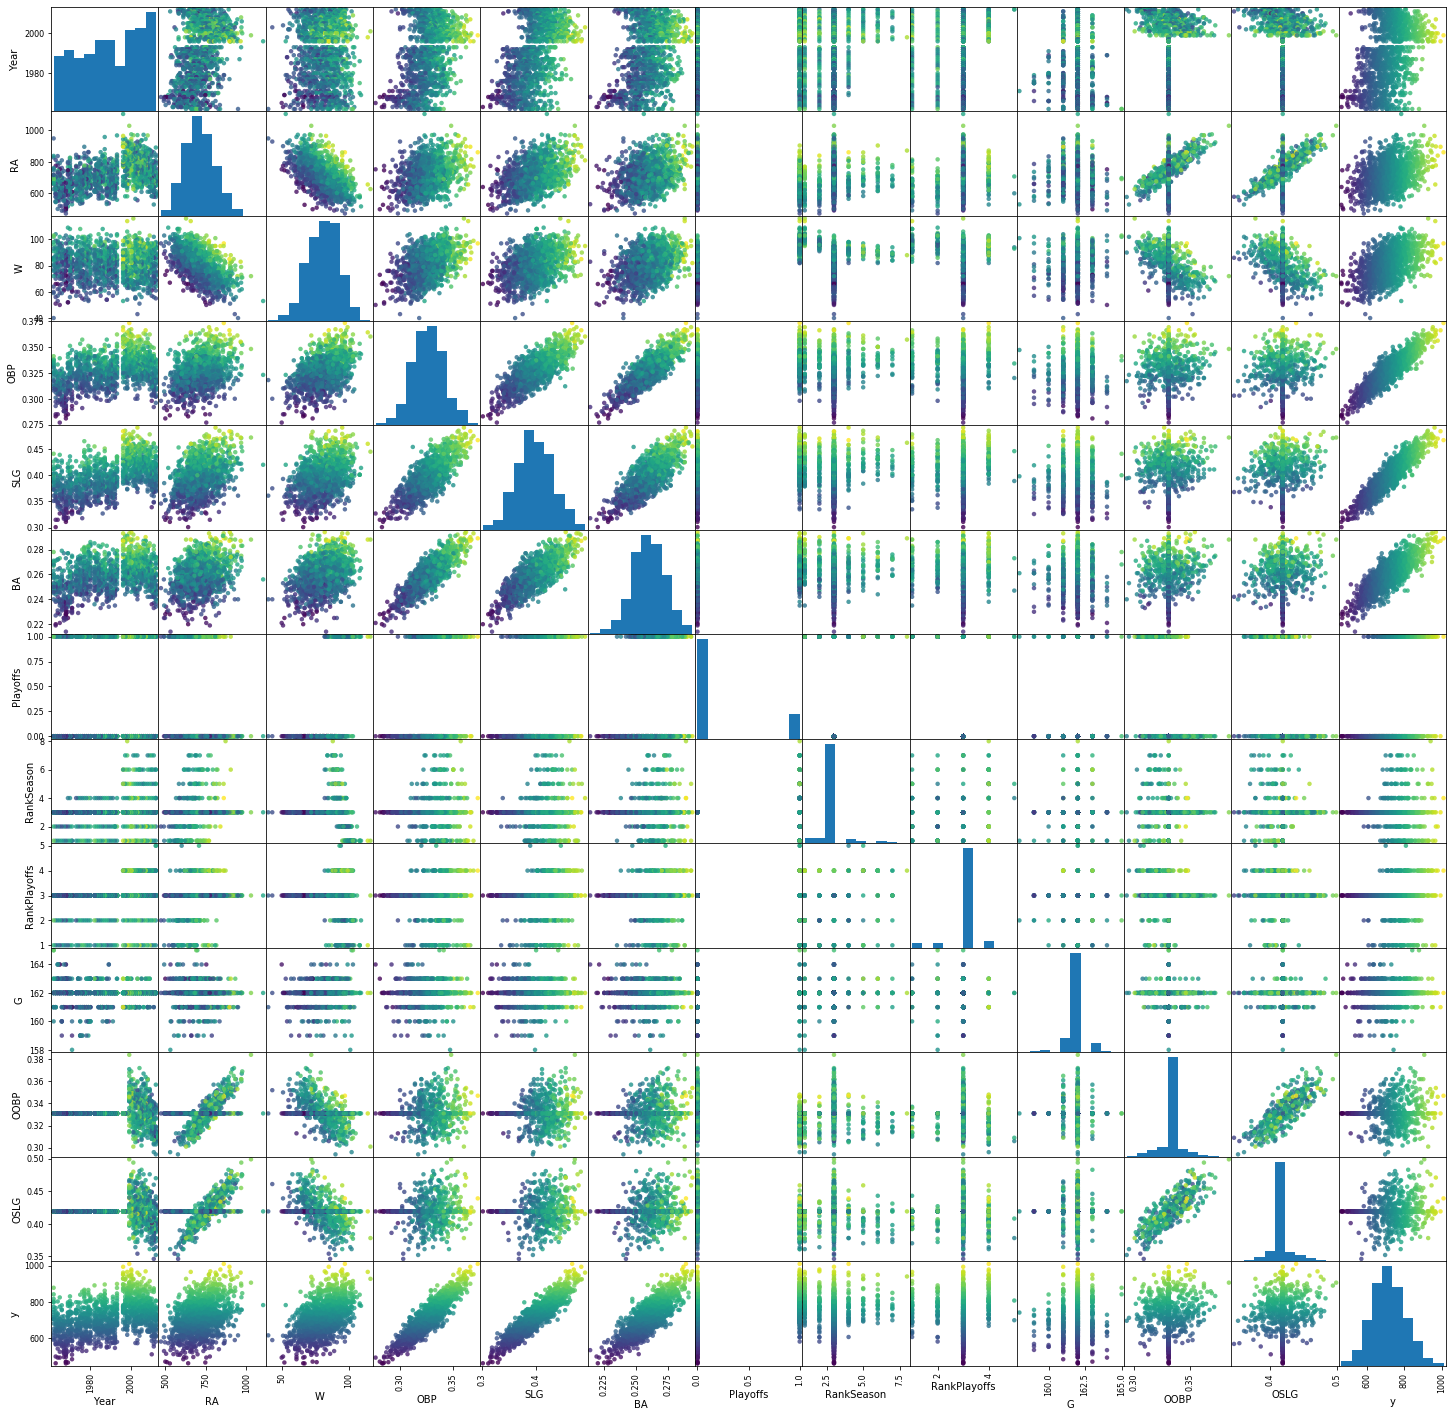

In [5]:
from pandas.plotting import scatter_matrix

# Scatter matrix of dataframe including the target feature
copyframe = X_clean.copy() 
copyframe['y'] = pd.Series(y, index=copyframe.index)
scatter_matrix(copyframe, c=y, figsize=(25,25), 
               marker='o', s=20, alpha=.8, cmap='viridis');

Several things immediately stand out:
* OBP, SLG and BA strongly correlate with the target (near-diagonals in the final column), but also combinations of either of these and W or R seem useful.
* RA, W, OBP, SLG and BA seem normally distributed, most others do not. 
* OOBP and OSLG have a very peaked distribution. 
* 'Playoffs' seems to be categorical and should probably be encoded as such. 

## Exercise 1: Build a pipeline

Implement a function `build_pipeline` that does the following:
- Impute missing values by replacing NaN's with the feature median for numerical features.
- Encode the categorical features using OneHotEncoding.
- If the attribute `scaling=True`, also scale the data using standard scaling.
- Attach the given regression model to the end of the pipeline

In [6]:
def build_pipeline(regressor, numerical, categorical, scaling=False):
    """ Build a robust pipeline with the given regression model
    Keyword arguments:
    regressor -- the regression model
    categorical -- the list of categorical features
    scaling -- whether or not to scale the data
    
    Returns: a pipeline
    """
    pass

In [22]:
### Model solution
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

def build_pipeline(regressor, categorical, scaling=False):
    cat_pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore'))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
    if scaling:
        num_pipe.steps.insert(1,["scaler", StandardScaler()]) 
    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    # Give a name to the regressor so that we can tune it more easily
    return Pipeline(steps=[('preprocess', transform), ('reg', regressor)])

## Exercise 2: Test the pipeline
Test the pipeline by evaluating linear regression (without scaling) on the dataset, using 5-fold cross-validation and $R^2$. Make sure to run it on the original dataset ('X'), not the manually cleaned version ('X_clean').

In [23]:
### Model solution
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
categorical = ["Team","League"]
regressor = LinearRegression()
pipe = build_pipeline(LinearRegression(),categorical)
scores = cross_val_score(pipe, X, y)
print("Cross-validated R^2 score for {}: {:.2f}".format(regressor.__class__.__name__, scores.mean()))

Cross-validated R^2 score for LinearRegression: 0.92


## Exercise 3: A first benchmark
Evaluate the following algorithms in their default settings, both with and without scaling, and interpret the results:  
- Linear regression
- Ridge
- Lasso
- SVM (RBF)
- RandomForests
- GradientBoosting

In [24]:
### Model solution
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm

models = [LinearRegression(), Ridge(), Lasso(), RandomForestRegressor(), GradientBoostingRegressor(), SVR()]
for m in tqdm(models):
    pipe = build_pipeline(m,categorical)
    scores = cross_val_score(pipe, X, y)
    print("R^2 score for {}: {:.2f}".format(m.__class__.__name__, scores.mean()))
    pipe = build_pipeline(m,categorical, scaling=True)
    scores = cross_val_score(pipe, X, y)
    print("R^2 score for {} (scaled): {:.2f}".format(m.__class__.__name__, scores.mean()))

R^2 score for LinearRegression: 0.92
R^2 score for LinearRegression (scaled): -22898115995987259424768.00
R^2 score for Ridge: 0.83
R^2 score for Ridge (scaled): 0.92
R^2 score for Lasso: 0.81
R^2 score for Lasso (scaled): 0.92
R^2 score for RandomForestRegressor: 0.89
R^2 score for RandomForestRegressor (scaled): 0.89
R^2 score for GradientBoostingRegressor: 0.91
R^2 score for GradientBoostingRegressor (scaled): 0.91
R^2 score for SVR: -0.46
R^2 score for SVR (scaled): 0.27



### Discussion
Without scaling: LinearRegression without scaling works better than Ridge and Lasso. The latter two are perhaps overfitting and need to be tuned. RandomForest and GradientBoosting do well (almost as good as LinearRegression), but can still be improven. The SVM performs very badly (worse than simply predicting the mean).

Scaling helps performance significantly, except for LinearRegression which now seems to massively overfit. Since scaling also changes the scale of the coefficients, the default hyperparameter settings may just fit better after scaling for Ridge and Lasso, but not for the unregularized LinearRegression. Indeed, if one feature had a very different scale, the corresponding coefficient has to compensate for this, leading to possibly large coefficients and more likely overfitting. Thus, scaling may sometimes act as a regularizer. The SVM improves a lot after scaling but there is still a lot more room for tuning. The tree-based models are, as expected, not affected by scaling.

Note: the extremely bad result for scaled linear regression is caused by a single bad train-test split. If we try different splits we get:

In [30]:
pipe = build_pipeline(LinearRegression(),categorical,scaling=True)
scores = cross_val_score(pipe, X, y, cv=8)
print("R^2 score for {}: {:.2f}".format(LinearRegression().__class__.__name__, scores.mean()))

R^2 score for LinearRegression: 0.92


## Exercise 4: Tuning linear models
Next, visualize the effect of the alpha regularizer for Ridge and Lasso. Vary alpha from 1e-4 to 1e6 and plot the $R^2$ score as a line plot (one line for each algorithm). Always use scaling. Interpret the results.

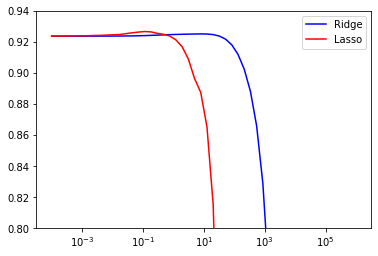

Best result 0.927 with {'reg__alpha': 0.11513953993264481}


In [31]:
from sklearn.model_selection import GridSearchCV 
import numpy as np
import matplotlib.pyplot as plt

grid_alpha = {'reg__alpha': np.logspace(-4, 6, num=50)}

# Build a pipeline and runs a grid search
def evaluateGrid(regressor, grid, scaling=False):
    pipe = build_pipeline(regressor, categorical, scaling=scaling)
    return GridSearchCV(pipe, grid, n_jobs=-1).fit(X, y)

ridge_res = evaluateGrid(Ridge(), grid_alpha, True)
_=plt.plot([d['reg__alpha'] for d in ridge_res.cv_results_['params']], 
           ridge_res.cv_results_['mean_test_score'], 'b', label='Ridge')
lasso_res = evaluateGrid(Lasso(), grid_alpha, True)
_=plt.plot([d['reg__alpha'] for d in lasso_res.cv_results_['params']], 
           lasso_res.cv_results_['mean_test_score'], 'r', label='Lasso')
_=plt.xscale('log')
_=plt.ylim([0.8, 0.94])
plt.legend()
plt.show();
print("Best result {:.3f} with {}".format(lasso_res.best_score_, lasso_res.best_params_));

### Discussion
Lasso (red line) finds a slightly better model than Ridge, with an optional alpha of around 0.1 (you may need to zoon in to see it). For values larger than 10, Lasso starts underfitting heavily (it penalizes large coefficients too much), and $R^2$ drops to 0 (and lower). Ridge is slighlty less sensitive to alpha and only starts overfitting heavily for alpha values of 1000 or larger.

## Exercise 5: Tuning SVMs
Next, tune the SVM's C and gamma. You can stay within the 1e-6 to 1e6 range. Plot the $R^2$ score as a heatmap.

In [32]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

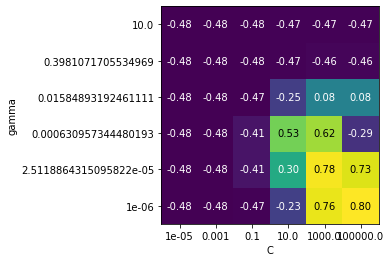

In [33]:
def svm_heat(scaling=False):
    # Run a 2D grid search and build a heatmap with the results
    grid_svm = {'reg__C': np.logspace(-5, 5, num=6),
                'reg__gamma': np.logspace(-6, 1, num=6)}
    svm_res = evaluateGrid(SVR(), grid_svm, scaling=scaling)

    # Reshape and transpose (we want alpha on the x-axes to compare with the previous plot)
    scores = svm_res.cv_results_['mean_test_score'].reshape(grid_svm['reg__C'].size,
                                                            grid_svm['reg__gamma'].size).T
    heatmap(scores, xlabel='C', xticklabels=grid_svm['reg__C'],
            ylabel='gamma', yticklabels=grid_svm['reg__gamma'], cmap="viridis");

svm_heat()

## Exercise 5b: Tuning SVMs (2)
Redraw the heatmap, but now use scaling. What do you observe?

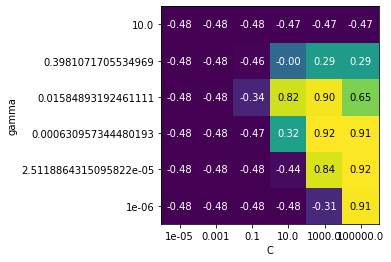

In [34]:
svm_heat(scaling=True)

The tuned SVM yields scores that are identical to the best scores found (0.92 $R^2$), but only if we do scaling. 
Without scaling, we get nowhere near that performance, no matter how much we tune.

## Exercise 6: Feature importance 
Retrieve the coefficients from the optimized Lasso, Ridge, and the feature importances from the default RandomForest and GradientBoosting models.
Compare the results. Do the different models agree on which features are important? You will need to map the encoded feature names to the correct coefficients and feature importances.

In [35]:
# The OneHotEncoder has messed up our attribute names, so we must map features to names again
# feature_indices_ returns a mapping for the one-hot-encoded features
fi = lasso_res.best_estimator_.named_steps['preprocess'].named_transformers_['pipeline'].named_steps['onehotencoder'].get_feature_names(input_features=categorical)
new_names = list(fi)
new_names.extend(attribute_names[2:])

In [36]:
# We additionally train a RandomForest and Gradient Booster to see if they return the same feature importances
rf_pipe = build_pipeline(RandomForestRegressor(),categorical)
rf_pipe.fit(X, y);
gb_pipe = build_pipeline(GradientBoostingRegressor(),categorical)
gb_pipe.fit(X, y);

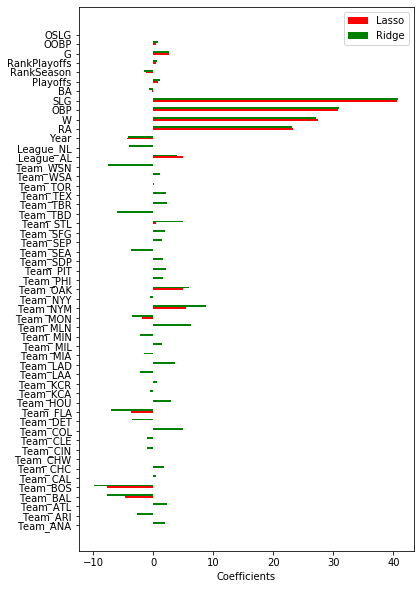

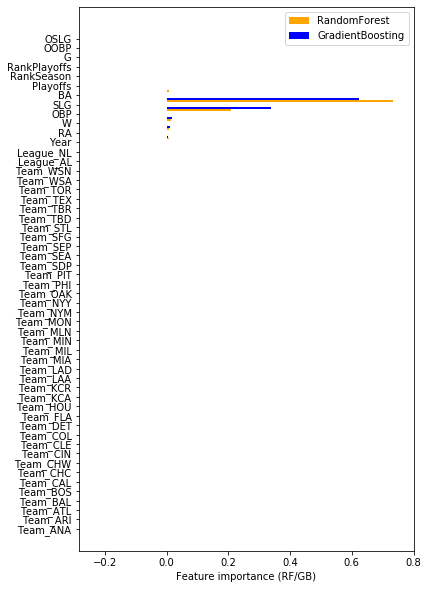

In [37]:
df = pd.DataFrame({'names': new_names, 
                   'lasso': lasso_res.best_estimator_.get_params()['reg'].coef_,
                   'ridge': ridge_res.best_estimator_.get_params()['reg'].coef_,
                   'random_forest': rf_pipe.named_steps.reg.feature_importances_,
                   'gradient_boosting': gb_pipe.named_steps.reg.feature_importances_})
ind = np.arange(len(df))
width = 0.2

# Coefficients
fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(ind, df.lasso, width, color='red', label='Lasso')
ax.barh(ind + width, df.ridge, width, color='green', label='Ridge')
ax.set_yticklabels(new_names)
ax.set_yticks(np.arange(len(new_names)))
ax.set_xlabel('Coefficients')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6, 10))
# RandomForest feature importances
ax.barh(ind + width*2, df.random_forest, width, color='orange', label='RandomForest')
ax.barh(ind + width*3, df.gradient_boosting, width, color='blue', label='GradientBoosting')
ax.set_yticklabels(new_names)
ax.set_yticks(np.arange(len(new_names)))
ax.set_xlabel('Feature importance (RF/GB)')
ax.set_xlim(-0.285, 0.8) #
ax.legend()
plt.show()

Ridge and lasso roughly agree on the importance of features. Especially SLG, OBP, W, and RA are deemed important, and to a lesser degree Year. Also, interestingly, it seems to matter whether the player plays in the American League (League_AL) or not, and playing in some teams (BOSton, BALtimore, NYMets, OAKland) is also a good indicator. 

One very obvious phenomenon is that Ridge considers all the one-hot-encoded features to be quite important. Since ridge uses the L2 norm, it will prefer many small coefficients, whereas Lasso (L1 norm) prefers to have many coefficients equal to 0. This is exactly what we are seeing here. From the plots above, we've seen that Ridge performs worse than Lasso, and the rather large coefficients for one-hot-encoded features hint at overfitting.

RandomForest and GradientBoosting deem especially SLG and OBP important. All the one-hot-encoded features have an importance of about 0.